In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'#'LiH'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]#[('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end
QubitHamiltonian

(-0.09706626861762624+0j) [] +
(-0.04530261550868928+0j) [X0 X1 Y2 Y3] +
(0.04530261550868928+0j) [X0 Y1 Y2 X3] +
(0.04530261550868928+0j) [Y0 X1 X2 Y3] +
(-0.04530261550868928+0j) [Y0 Y1 X2 X3] +
(0.17141282639402405+0j) [Z0] +
(0.1686889816869329+0j) [Z0 Z1] +
(0.12062523481381837+0j) [Z0 Z2] +
(0.16592785032250768+0j) [Z0 Z3] +
(0.171412826394024+0j) [Z1] +
(0.16592785032250768+0j) [Z1 Z2] +
(0.12062523481381837+0j) [Z1 Z3] +
(-0.2234315367466397+0j) [Z2] +
(0.174412876106516+0j) [Z2 Z3] +
(-0.2234315367466397+0j) [Z3]

In [2]:
################## get sets for UP

Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1023.30it/s]


{0: [(0.1686889816869329+0j) [Z0 Z1]],
 1: [(0.12062523481381837+0j) [Z0 Z2]],
 2: [(0.12062523481381837+0j) [Z1 Z3]],
 3: [(0.16592785032250768+0j) [Z0 Z3]],
 4: [(0.16592785032250768+0j) [Z1 Z2]],
 5: [(0.174412876106516+0j) [Z2 Z3]],
 6: [(-0.09706626861762624+0j) []],
 7: [(0.171412826394024+0j) [Z1], (0.04530261550868928+0j) [Y0 X1 X2 Y3]],
 8: [(-0.2234315367466397+0j) [Z2], (0.04530261550868928+0j) [X0 Y1 Y2 X3]],
 9: [(-0.2234315367466397+0j) [Z3], (-0.04530261550868928+0j) [X0 X1 Y2 Y3]],
 10: [(0.17141282639402405+0j) [Z0], (-0.04530261550868928+0j) [Y0 Y1 X2 X3]]}

In [4]:
######### Ansatz circuit

from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
H2_ansatz(np.pi)  

0: ───X───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───
                     │                              │
1: ───X───H──────────X───@──────────────────────@───X───H───────────
                         │                      │
2: ───H──────────────────X───@──────────────@───X───H───────────────
                             │              │
3: ───H──────────────────────X───Rz(2.0π)───X───H───────────────────

In [98]:
from quchem.LCU_method import *
from quchem.Unitary_partitioning import * 
from quchem.quantum_circuit_functions import *

class circuit_setup():
    def __init__(self, anti_commuting_set, S_index=0, N_index=0):
        self.anti_commuting_set = anti_commuting_set
        self.N_index = N_index
        self.S_index = S_index
    
    def ansatz_circuit_setup(self, theta):
        return H2_ansatz(theta) 
    
    def LCU_Q_circuit(self, theta):
        
        R_uncorrected, Pn, gamma_l = Get_R_linear_combination(self.anti_commuting_set, self.N_index)
        R_corrected_Op_list, R_corr_list, ancilla_amplitudes, l1_norm = absorb_complex_phases(R_uncorrected)
        
        ansatz_circuit = self.ansatz_circuit_setup(theta)
        
        LCU_Q_circuit = Full_Q_Circuit(Pn,
                                       R_corrected_Op_list,
                                       R_corr_list,
                                       ancilla_amplitudes,
                                       Hamilt.molecule.n_qubits,
                                       ansatz_circuit)
        
        return LCU_Q_circuit, l1_norm, gamma_l, Pn, ancilla_amplitudes
    
    def Conj_Q_circuit(self, theta):
        
        normalised_set = Get_beta_j_cofactors(self.anti_commuting_set)
        X_sk_dict = Get_X_sk_operators(normalised_set, S=self.S_index)

        ansatz_circuit = self.ansatz_circuit_setup(theta) 
        Conj_Q_circuit = Generate_Full_Q_Circuit_unitary_part(ansatz_circuit, X_sk_dict)

        Ps = X_sk_dict['PauliWord_S']
        gamma_l = X_sk_dict['gamma_l']
        
        return Conj_Q_circuit, gamma_l, Ps
    
    def standard_VQE_circuits(self, theta):
        
        ansatz_circuit = self.ansatz_circuit_setup(theta)
        
        Q_circ_list=[]
        qubitOp_list=[]
        for qubitOp in self.anti_commuting_set:
            Q_circuit = Generate_Full_Q_Circuit(ansatz_circuit, qubitOp)
            Q_circ_list.append(Q_circuit)
            qubitOp_list.append(qubitOp)
        
        return qubitOp_list, Q_circ_list
            
        
    

In [102]:
# print('################################################################################')
# set_index = 9
# S_index = 1
# N_index= 1

# ##

# test = circuit_setup(anti_commuting_sets[set_index], S_index=S_index, N_index=N_index)
# LCU_Q_circuit, l1_norm, gamma_l, Pn, ancilla_amplitudes =test.LCU_Q_circuit(np.pi)
# print(LCU_Q_circuit.to_text_diagram(transpose=False)) 

# print('')
# print('##')
# print('')

# Conj_Q_circuit, gamma_l, Ps =test.Conj_Q_circuit(np.pi)
# print(Conj_Q_circuit.to_text_diagram(transpose=False)) 

# print('')
# print('##')
# print('')

# qubitOp_list, Q_circ_list =test.standard_VQE_circuits(np.pi)

# for circ in Q_circ_list:
#     print(circ.to_text_diagram(transpose=False))
#     print('')
#     print('##')
#     print('')



In [103]:
class simulate_different_methods(circuit_setup):
    def __init__(self,anti_commuting_set, N_system_qubits, n_shots, S_index=0, N_index=0):
        
        super().__init__(anti_commuting_set, S_index=S_index, N_index=N_index)
        
        self.N_system_qubits = N_system_qubits
        self.n_shots = n_shots
        
    def Calc_Energy_of_set_LCU(self, theta):
        LCU_Q_circuit, l1_norm, gamma_l, Pn, ancilla_amplitudes =self.LCU_Q_circuit(theta)
        output_bin_dict = Get_binary_dict_project(LCU_Q_circuit, Pn, self.n_shots, self.N_system_qubits, ancilla_amplitudes, l1_norm)
        exp_result = expectation_value_by_parity(output_bin_dict).real
        return (exp_result * gamma_l)
    
    def Calc_Energy_of_set_CONJ(self, theta):
        
        Conj_Q_circuit, gamma_l, Ps =self.Conj_Q_circuit(theta)
            
        const = list(Ps.terms.values())[0]
        hist_key_str = Get_Histogram_key(Ps)
        int_state_counter = Simulate_Quantum_Circuit(Conj_Q_circuit, self.n_shots, hist_key_str)
        
        binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
        exp_result = expectation_value_by_parity(binary_state_counter).real
        
        return (exp_result * gamma_l)
    
    def Calc_energy_standard(self, theta):
        
        qubitOp_list, Q_circ_list =self.standard_VQE_circuits(theta)
        
        list_E_results=[]
        for index, qubitOp in enumerate(qubitOp_list):
            
            const = list(qubitOp.terms.values())[0]
            
            hist_key_str = Get_Histogram_key(qubitOp)
            int_state_counter = Simulate_Quantum_Circuit(Q_circ_list[index], self.n_shots, hist_key_str)
            binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
            exp_result = expectation_value_by_parity(binary_state_counter).real
            
            list_E_results.append(exp_result*const)
            
        return list_E_results

In [105]:
n_shots=1000
ww = simulate_different_methods(anti_commuting_sets[9], Hamilt.molecule.n_qubits, n_shots, S_index=0, N_index=0)

print(ww.Calc_Energy_of_set_LCU(np.pi))
print(ww.Calc_Energy_of_set_CONJ(np.pi))
print(ww.Calc_energy_standard(np.pi))

(-0.22341846171015362+0j)
(-0.22661015402029866+0j)
[(-0.2234315367466397+0j), (0.0013590784652606784-0j)]


In [36]:
### looking at results

In [106]:
angle_scan = np.arange(0,2*np.pi, 0.1)

n_shots=1000
set_index = 9
S_index= 0
N_index = 0

E_standard=[]
E_LCU=[]
E_conj=[]
for theta in angle_scan:
    setup_run = simulate_different_methods(anti_commuting_sets[set_index], Hamilt.molecule.n_qubits, n_shots, S_index=S_index, N_index=N_index)
    
    E_standard.append(setup_run.Calc_energy_standard(theta))
    E_LCU.append(setup_run.Calc_Energy_of_set_LCU(theta))
    E_conj.append(setup_run.Calc_Energy_of_set_CONJ(theta))

E_standard = np.array(E_standard)

/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

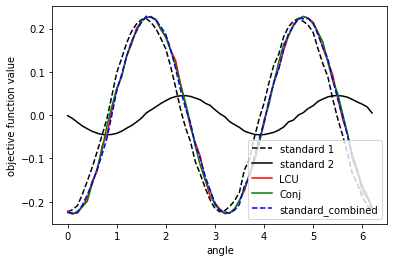

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(angle_scan, E_standard[:, 0], label = "standard 1",  linestyle='--', linewidth=1.5, color='black')
plt.plot(angle_scan,E_standard[:, 1], label = "standard 2", linestyle='-', linewidth=1.5, color='black')
plt.plot(angle_scan,E_LCU, label = "LCU", linestyle='-', linewidth=1.5, color='red')
plt.plot(angle_scan,E_conj, label = "Conj", linestyle='-', linewidth=1.5, color='green')
plt.plot(angle_scan,E_standard[:, 0] + E_standard[:, 1], label = "standard_combined", linestyle='--', linewidth=1.5, color='blue')


plt.xlabel('angle')
plt.ylabel('objective function value')
plt.legend()
plt.show()

Set index: 7


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

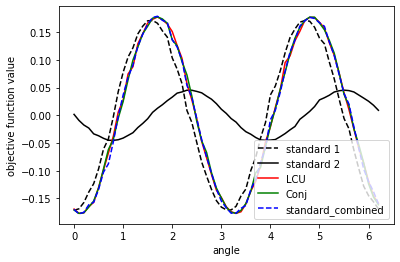

Set index: 8


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

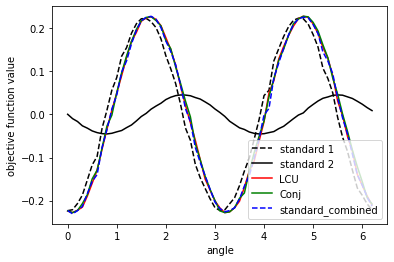

Set index: 9


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

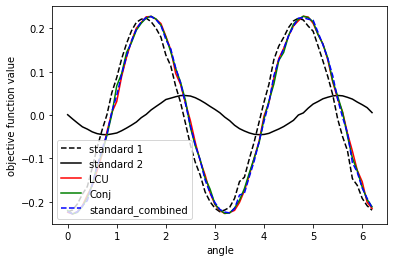

Set index: 10


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

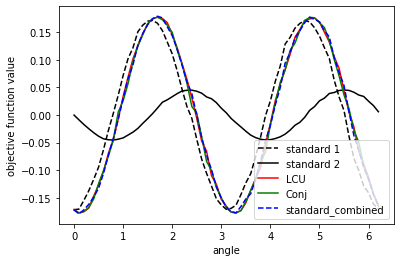

In [108]:
angle_scan = np.arange(0,2*np.pi, 0.1)

n_shots=1000
S_index= 0
N_index = 0

for set_index in [7,8,9,10]:
    

    E_standard=[]
    E_LCU=[]
    E_conj=[]
    for theta in angle_scan:
        setup_run = simulate_different_methods(anti_commuting_sets[set_index], Hamilt.molecule.n_qubits, n_shots, S_index=S_index, N_index=N_index)

        E_standard.append(setup_run.Calc_energy_standard(theta))
        E_LCU.append(setup_run.Calc_Energy_of_set_LCU(theta))
        E_conj.append(setup_run.Calc_Energy_of_set_CONJ(theta))

    E_standard = np.array(E_standard)

    print('Set index:', set_index)
    plt.figure()
    plt.plot(angle_scan, E_standard[:, 0], label = "standard 1",  linestyle='--', linewidth=1.5, color='black')
    plt.plot(angle_scan,E_standard[:, 1], label = "standard 2", linestyle='-', linewidth=1.5, color='black')
    plt.plot(angle_scan,E_LCU, label = "LCU", linestyle='-', linewidth=1.5, color='red')
    plt.plot(angle_scan,E_conj, label = "Conj", linestyle='-', linewidth=1.5, color='green')
    plt.plot(angle_scan,E_standard[:, 0] + E_standard[:, 1], label = "standard_combined", linestyle='--', linewidth=1.5, color='blue')


    plt.xlabel('angle')
    plt.ylabel('objective function value')
    plt.legend()
    plt.show()

Set index: 7


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

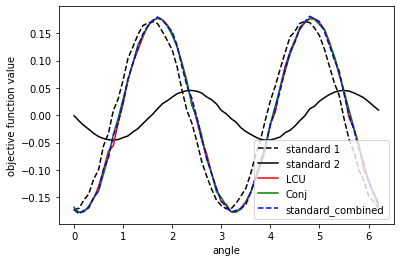

Set index: 8


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

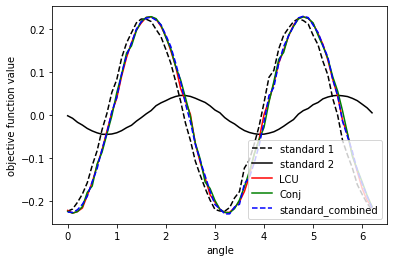

Set index: 9


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

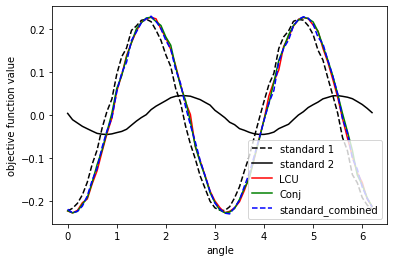

Set index: 10


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting c

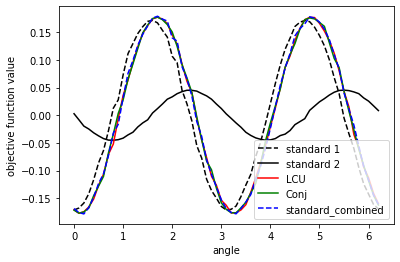

In [109]:
angle_scan = np.arange(0,2*np.pi, 0.1)

n_shots=1000
S_index= 1
N_index = 1

for set_index in [7,8,9,10]:
    

    E_standard=[]
    E_LCU=[]
    E_conj=[]
    for theta in angle_scan:
        setup_run = simulate_different_methods(anti_commuting_sets[set_index], Hamilt.molecule.n_qubits, n_shots, S_index=S_index, N_index=N_index)

        E_standard.append(setup_run.Calc_energy_standard(theta))
        E_LCU.append(setup_run.Calc_Energy_of_set_LCU(theta))
        E_conj.append(setup_run.Calc_Energy_of_set_CONJ(theta))

    E_standard = np.array(E_standard)

    print('Set index:', set_index)
    plt.figure()
    plt.plot(angle_scan, E_standard[:, 0], label = "standard 1",  linestyle='--', linewidth=1.5, color='black')
    plt.plot(angle_scan,E_standard[:, 1], label = "standard 2", linestyle='-', linewidth=1.5, color='black')
    plt.plot(angle_scan,E_LCU, label = "LCU", linestyle='-', linewidth=1.5, color='red')
    plt.plot(angle_scan,E_conj, label = "Conj", linestyle='-', linewidth=1.5, color='green')
    plt.plot(angle_scan,E_standard[:, 0] + E_standard[:, 1], label = "standard_combined", linestyle='--', linewidth=1.5, color='blue')


    plt.xlabel('angle')
    plt.ylabel('objective function value')
    plt.legend()
    plt.show()